# Home App 
## Part II- Predict the price of home using desired variables

The data for this project comes from Kaggle  [House Sales in King County, USA](https://www.kaggle.com/architdxb/king-countyusa/data). The list of variables is shown below.

The variables:

* **id** : house identification number
* **date** : date house was sold
* **price** : target variable for prediction
* **bedrooms** : number of bedrooms in the home
* **bathrooms** : number of bathrooms in the home
* **sqft_living** : square footage of the home
* **sqft_lot** : square footage of the lot
* **floors** : total floors in the home
* **waterfront** : 1 for home with a waterfront view, 0 otherwise
* **view** : has been viewed or not
* **condition** : How good the condition is overall
* **grade** : overall grade given to the housing unit, based on king county grading system
* **sqft_above** : square footage of home apart from basement
* **sqft_basement** : square footage of the basement
* **yr_built** : year the home was built
* **yr_renovated** : year the home was renovated
* **zipcode** : zip code of the home
* **lat** : latitude coordinate of the home
* **long** : longitude coordinate of the home
* **sqft_living15** : living room area in 2015
* **sqft_lot15** : lot area in 2015

For this part of the project, we will only use id, price, bedrooms, bathrooms, sqft_living, sqft_lot, yr_built and yr_renovated for our model. 

For part II of the project, we will: 

1. Read the documentation and familiarize yourself with the dataset. 
2. Combine all of the data files into one large dataset. 
3. Split the data into training/validation/test sets. 
4. Perform data visualization to examine the features. 
5. Train a model with the supervised ML method with lowest mean square error. 
6. Perform parameter tuning to acquire a model with better performance. 
 


### I. Load and Merge Data

In [1]:
# load necessary packages 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import glob
import itertools
import seaborn as sns
from scipy import stats
from time import time

# pretty display for notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

from IPython.display import display # Allows the use of display() for DataFrames

# hide warnings
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

data_path = "C:/Users/Yiruru/Documents/launchCode/data/kc_house_data2.csv"

# Load and merge the housing data
try:
    df = pd.read_csv(data_path)
    print("Main dataset has {} samples with {} features each.".format(*df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Main dataset has 21613 samples with 21 features each.


The properties_2017.csv file contains details on the properties, and the train_2017.csv provides the actual log error for training purpose. Therefore, the goal here is to predict the log error using the properties of the houses. There are 58 properties, so we should perform some dimension reduction first. 

However, for the purpose of initial test, a smaller model will be built using only bedroomcnt, bathroomcnt, and calculatedfinishedsquarefeet.

### II. Data Exploration 

In [2]:
# reset index to id
df = df.set_index('id')
print ('Table 1: Sample Data from main dataset')
df.head(3)

Table 2.1: Sample Data from main dataset


date     price  bedrooms  bathrooms  sqft_living  \
id                                                                        
7129300520  20141013T000000  221900.0  3         1.00       1180          
6414100192  20141209T000000  538000.0  3         2.25       2570          
5631500400  20150225T000000  180000.0  2         1.00       770           

            sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
id                                                                             
7129300520  5650      1.0     0           0     3          7      1180         
6414100192  7242      2.0     0           0     3          7      2170         
5631500400  10000     1.0     0           0     3          6      770          

            sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
id                                                                             
7129300520  0              1955      0             98178    47.5112 -122.257   
6414100192  400            1951      1991          98125    47.7210 -122.319   
5631500400  0              1933      0             98028    47.7379 -122.233   

            sqft_living15  sqft_lot15  
id                                     
7129300520  1340           5650        
6414100192  1690           7639        
5631500400  2720           8062

In [3]:
print('Number of features:', df.shape[1])
train = df.select_dtypes(exclude=['object'])
print("")
print('Number of Numerical Features:', train.shape[1])

print("")
print("List of features contained our dataset:",list(train.columns))
%matplotlib inline

Number of features: 20

Number of Numerical Features: 19

List of features contained our dataset: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [4]:
display(train.describe)

<bound method NDFrame.describe of                 price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                          
7129300520  221900.0   3         1.00       1180         5650      1.0      
6414100192  538000.0   3         2.25       2570         7242      2.0      
5631500400  180000.0   2         1.00       770          10000     1.0      
2487200875  604000.0   4         3.00       1960         5000      1.0      
1954400510  510000.0   3         2.00       1680         8080      1.0      
7237550310  1230000.0  4         4.50       5420         101930    1.0      
1321400060  257500.0   3         2.25       1715         6819      2.0      
2008000270  291850.0   3         1.50       1060         9711      1.0      
2414600126  229500.0   3         1.00       1780         7470      1.0      
3793500160  323000.0   3         2.50       1890         6560      2.0      
1736800520  662500.0   3         2.50     

#### Check missing values

We can see below that there's no missing values in our data as the data has been processed before. 

In [55]:
# calculate % of missing value
total = train.isnull().sum().sort_values(ascending=False)
percent = (100*train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print('Table 2. Number of Missing Data for each Feature (Not used in doc)')
missing_data

Table 2. Number of Missing Data for each Feature (Not used in doc)


Total  Percent
sqft_lot15     0      0.0    
sqft_living15  0      0.0    
price          0      0.0    
bedrooms       0      0.0    
bathrooms      0      0.0    
sqft_living    0      0.0    
sqft_lot       0      0.0    
floors         0      0.0    
waterfront     0      0.0    
view           0      0.0    
condition      0      0.0    
grade          0      0.0    
sqft_above     0      0.0    
sqft_basement  0      0.0    
yr_built       0      0.0    
yr_renovated   0      0.0    
zipcode        0      0.0    
lat            0      0.0    
long           0      0.0    
id             0      0.0

### Visualize Feature Distributions

The scatterplot matrix will reveal the correlation between the feature and another feature in the data. 

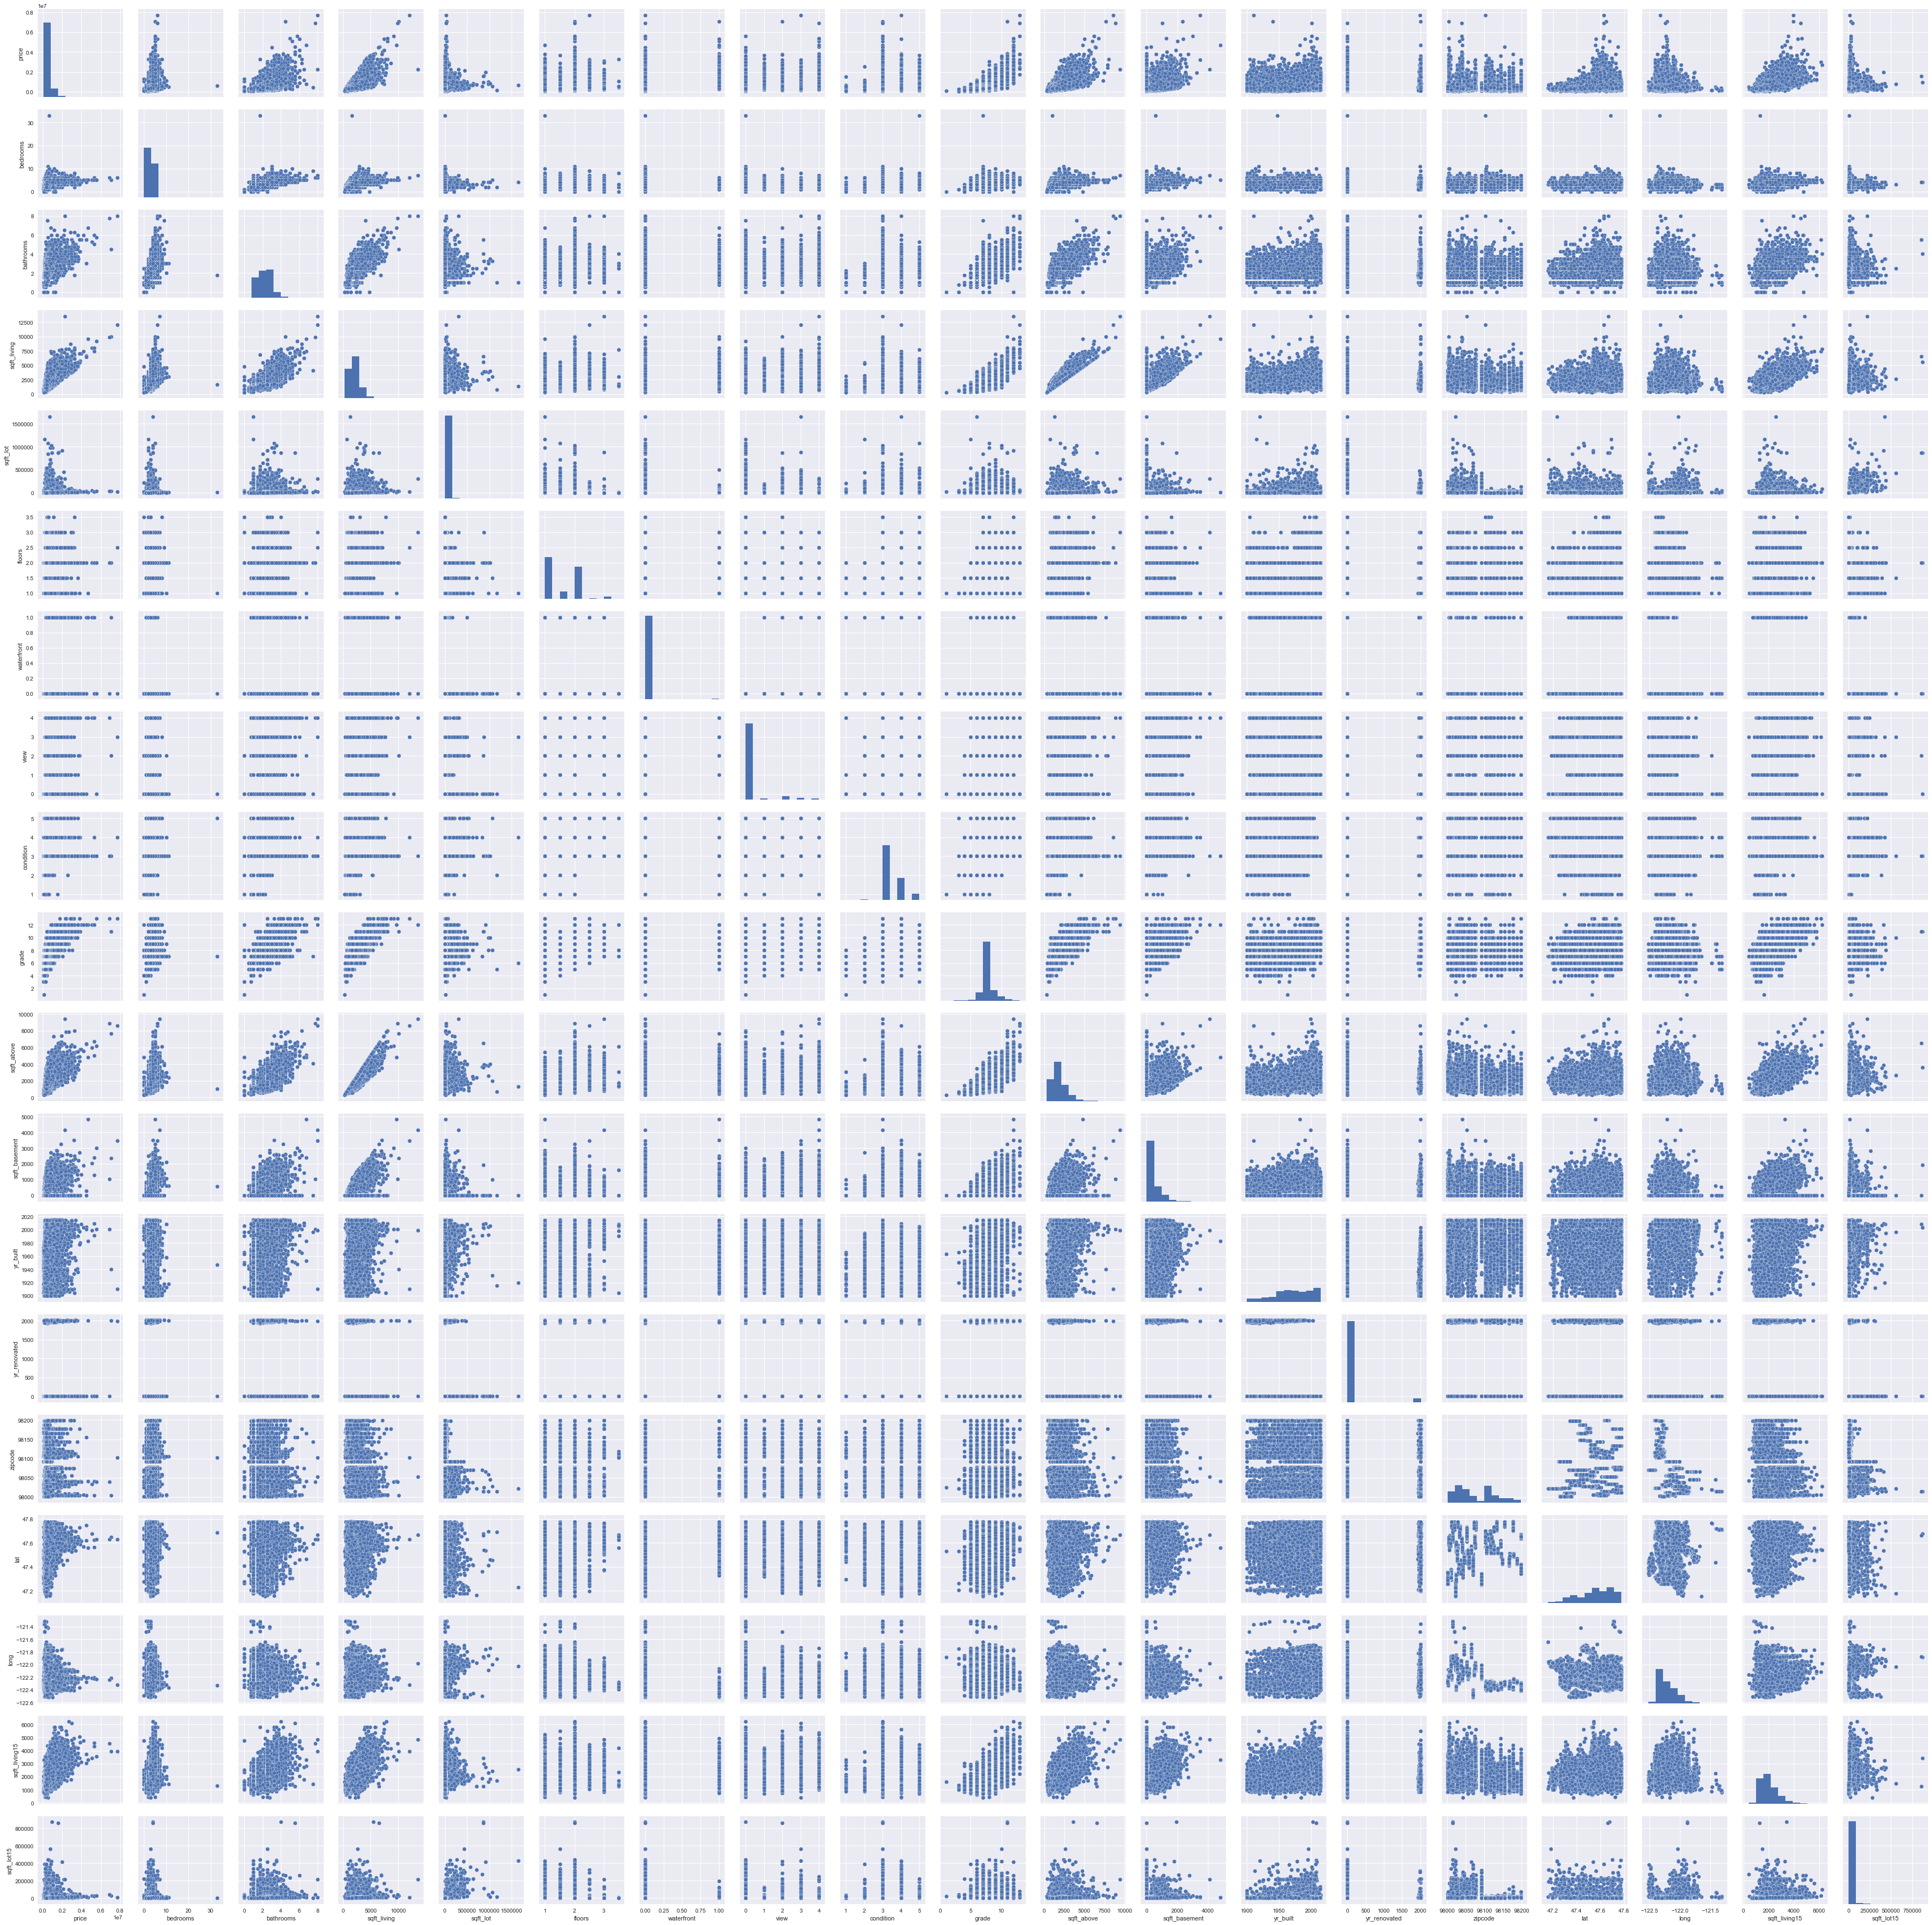

In [6]:
import seaborn as sns
sns.set()
sns.pairplot(train)
plt.show()

We can see that some variables are linearly correlated, so we should examine the correlation between variables before we proceed with modeling. 

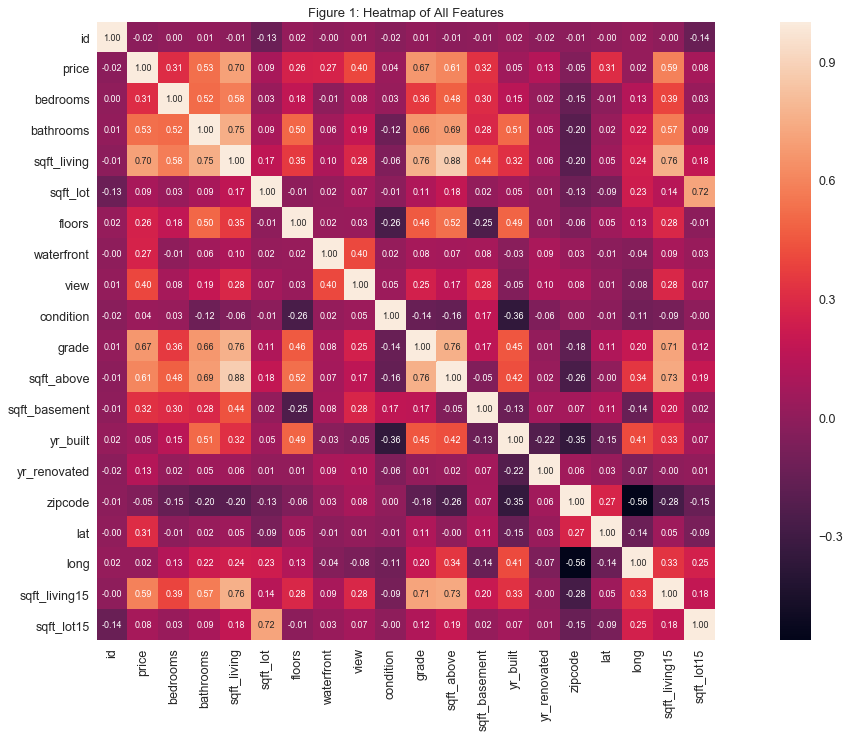

In [56]:
#saleprice correlation matrix
k = 19
cols = train.columns
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title('Figure 1: Heatmap of All Features', size = 13)
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.tight_layout()
plt.xticks(rotation=90);

Square_above and square_living are highly correlated (r = 0.88), and that makes sense. Square_above will be removed to avoid multicollinearity. 

We can see that calculatedbathnbr is highly correlated with fullbathcnt (r= 0.98) and bathroomcnt (r= 0.98). On the other hand, taxamount, landtaxvaluedollarcnt, taxvaluedollarcnt are highly correlated too. We will only use fullbathcnt and landtaxvaluedollarcnt as they're less correlated with other features. 

In [8]:
col_list = list()
for i in cols: 
    if i != 'price':
        col_list.append(i)
print(col_list)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [14]:
#col_list
new_col_list = col_list[0:4] + col_list[11:14]
current2 = train[new_col_list]
# create a year value that represent the most current time that the house went through any change
current2['year'] = current2[['yr_built', 'yr_renovated']].max(axis=1) 
current2 = current2[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'zipcode', 'year']]

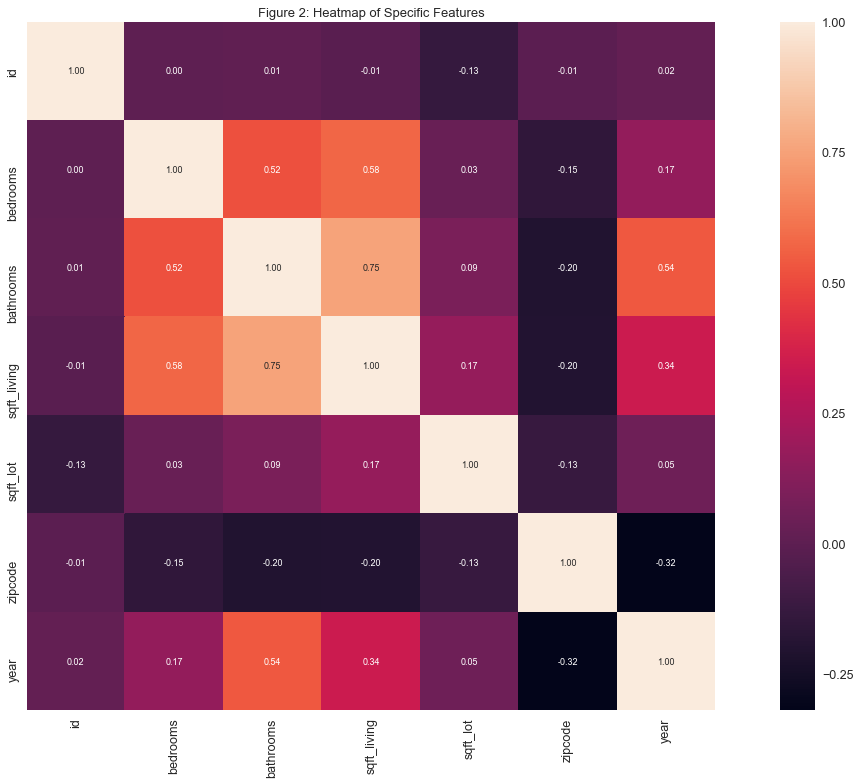

In [57]:
#saleprice correlation matrix
k = 6
cols = current2.columns
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title('Figure 2: Heatmap of Specific Features', size = 13)
cm = np.corrcoef(current2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.tight_layout()
plt.xticks(rotation=90);

In [18]:
current2 = current2.reset_index()
train = train.reset_index()
temp= train[['id', 'price']]
new_data = current2.merge(temp,on= 'id', how = 'inner')
new_data = new_data.set_index('id')

In [20]:
x_var = new_data.columns[:-1]; y_var = new_data.columns[-1]

### Train/Test data Split

Majority of the features have too many missing values, so we will only consider features with less than 10% of missing values. 

In [22]:
new_data.head(2)

bedrooms  bathrooms  sqft_living  sqft_lot  zipcode  year  \
id                                                                      
7129300520  3         1.00       1180         5650      98178    1955   
6414100192  3         2.25       2570         7242      98125    1991   

               price  
id                    
7129300520  221900.0  
6414100192  538000.0

In [33]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'year', 'zipcode']
price_raw = new_data['price']
features_raw = new_data.drop('price', axis = 1)
features_raw[numerical] = scaler.fit_transform(new_data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))
features = pd.get_dummies(features_raw)
price = new_data['price']

# Train and Test 
X = new_data.ix[:, :-1]
Y = new_data.ix[:, -1]

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(x_train.shape[0]))
print("Validation set has {} samples.".format(x_val.shape[0]))
print("Testing set has {} samples.".format(x_test.shape[0]))

# confirm % of test set
print("Testing set is {}%.".format(round(1.*x_test.shape[0]/features.shape[0]*100, 2)))

bedrooms  bathrooms  sqft_living  sqft_lot   zipcode      year
id                                                                        
7129300520  0.090909  0.125      0.06717      0.003108  0.893939  0.478261

Training set has 15378 samples.
Validation set has 3296 samples.
Testing set has 3295 samples.
Testing set is 15.0%.


In [58]:
# Get data characteristics on the training set
n_train = round(len(x_train), 0)
n_val = round(len(x_val), 0)
n_test = round(len(x_test),1)

y_train_mean = y_train.mean()
y_val_mean = y_val.mean()
y_test_mean = y_test.mean()

basic_df = pd.DataFrame([['{:.0f}'.format(n_train), '{:.0f}'.format(n_val), '{:.0f}'.format(n_test)], 
                         ['{:.4f}'.format(y_train_mean), '{:.4f}'.format(y_val_mean), '{:.4f}'.format(y_test_mean)]], 
                        index=['Sample Size', 'log error'], 
                        columns=['Training Set', 'validation Set', 'Test Set'])
print('Table 3: Characteristics of Training, Validation, and Test Set')
basic_df

Table 3: Characteristics of Training, Validation, and Test Set


Training Set validation Set     Test Set
Sample Size  15378        3296           3295       
log error    540842.6695  529067.9600    534933.2155

### Modeling 

In [35]:
import xgboost

from sklearn import cross_validation
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

#create classifiers
xgbrg= XGBRegressor(objective="reg:linear", random_state=100) 
gbrg = GradientBoostingRegressor(random_state=100) 
rfrg = RandomForestRegressor(random_state=100) 
dtrg = DecisionTreeRegressor(random_state=100) 
abrg = AdaBoostRegressor(random_state=100) 
brg = BaggingRegressor(random_state=100)

# train classifiers
xgbrg.fit(x_train, y_train, eval_metric = 'rmse', verbose = False, eval_set = [(x_test, y_test)])
gbrg.fit(x_train, y_train)
rfrg.fit(x_train, y_train)
dtrg.fit(x_train, y_train)
abrg.fit(x_train, y_train)
brg.fit(x_train, y_train)

# obtain predictions
xgbpreds = xgbrg.predict(x_val)
gbpreds = gbrg.predict(x_val)
rfpreds = rfrg.predict(x_val)
dtpreds = dtrg.predict(x_val)
abpreds = abrg.predict(x_val)
bpreds = brg.predict(x_val)

print('\nXGB Mean Square error ', mean_squared_error(y_val,xgbpreds))
print('GradientBoosting Mean Square error" ', mean_squared_error(y_val,gbpreds))
print('RandomForest Mean Square error" ', mean_squared_error(y_val,rfpreds))
print('DecisionTree Mean Square error" ', mean_squared_error(y_val,dtpreds))
print('AdaBoost Mean Square error" ', mean_squared_error(y_val,abpreds))
print('Bagging Mean Square error" ', mean_squared_error(y_val,bpreds))


XGB Mean Square error  35369519611.43731
GradientBoosting Mean Square error"  34923116646.19493
RandomForest Mean Square error"  32285443824.027817
DecisionTree Mean Square error"  53364324816.17499
AdaBoost Mean Square error"  66391064388.877785
Bagging Mean Square error"  32450765836.80008


We can see that gradient boosting performs the best, but we will actually choose XGB model for its known superiority in terms of training speed. We will now perform model tuning on XGB model. 

In [36]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import cohen_kappa_score, make_scorer, precision_score, recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

scoring_function = make_scorer(mean_squared_error, greater_is_better=False)
target = 'price'
predictors = new_data.columns[0:-1]

In [37]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval= True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['price'],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
     
    #Print model report:
    print("\nModel Report")
    print("Mean Square error : %.4g" % metrics.mean_squared_error(dtrain['price'].values, dtrain_predictions))
    print("r2 Score : %.4g" % metrics.r2_score(dtrain['price'].values, dtrain_predictions))
    return dtrain_predictions

In [38]:
#combine x_train and y_train for model tuning 
df_train = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# get a benchmark performance with our initial values
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=100)

m1pred = modelfit(xgb1, df_train, predictors);

[0]	train-rmse:602546+1090.83	test-rmse:602940+8134.71
[1]	train-rmse:552709+1040.61	test-rmse:553839+8766.35
[2]	train-rmse:508203+960.483	test-rmse:509390+7562.28
[3]	train-rmse:470507+2155.98	test-rmse:472249+6514.04
[4]	train-rmse:435323+2732.44	test-rmse:437718+5981.07
[5]	train-rmse:404077+2644.35	test-rmse:407123+6029.11
[6]	train-rmse:376198+2206.88	test-rmse:379751+5363.95
[7]	train-rmse:352384+2614.44	test-rmse:356687+6351.09
[8]	train-rmse:331441+2757.37	test-rmse:336569+5774.12
[9]	train-rmse:313352+2683.93	test-rmse:319445+6439.34
[10]	train-rmse:296593+2688.99	test-rmse:303311+5989.64
[11]	train-rmse:282759+3593.02	test-rmse:290041+5739.72
[12]	train-rmse:270718+3584.95	test-rmse:278829+5623.19
[13]	train-rmse:259907+3416.24	test-rmse:268748+5465.93
[14]	train-rmse:250433+3408.83	test-rmse:260136+5304.65
[15]	train-rmse:242206+3089.67	test-rmse:252316+5145.43
[16]	train-rmse:234948+2925.41	test-rmse:245609+4868.51
[17]	train-rmse:228615+2178.57	test-rmse:240040+4063.32
[1

[147]	train-rmse:126006+595.067	test-rmse:173664+4170.36
[148]	train-rmse:125772+669.83	test-rmse:173603+4163.98
[149]	train-rmse:125522+708.156	test-rmse:173539+4098.23
[150]	train-rmse:125268+677.911	test-rmse:173398+4146.11
[151]	train-rmse:125068+724.476	test-rmse:173330+4080.83
[152]	train-rmse:124835+734.31	test-rmse:173339+4044.83
[153]	train-rmse:124639+687.707	test-rmse:173302+4084.01
[154]	train-rmse:124390+632.515	test-rmse:173227+4055
[155]	train-rmse:124183+729.216	test-rmse:173182+4052.38
[156]	train-rmse:123990+648.55	test-rmse:173082+4131.13
[157]	train-rmse:123747+756.618	test-rmse:173032+4101.47
[158]	train-rmse:123553+766.776	test-rmse:172946+4113.51
[159]	train-rmse:123273+754.921	test-rmse:172878+4090.85
[160]	train-rmse:123050+739.276	test-rmse:172747+4107.5
[161]	train-rmse:122847+709.69	test-rmse:172806+4227.22
[162]	train-rmse:122633+769.419	test-rmse:172794+4171.73
[163]	train-rmse:122429+785.27	test-rmse:172813+4198.64
[164]	train-rmse:122278+817.196	test-rms

[292]	train-rmse:103725+1072.7	test-rmse:169981+4119.64
[293]	train-rmse:103599+1082.69	test-rmse:169972+4138
[294]	train-rmse:103509+1093.94	test-rmse:169944+4109.15
[295]	train-rmse:103364+1045.98	test-rmse:169951+4141.28
[296]	train-rmse:103266+1063.55	test-rmse:169913+4161.79
[297]	train-rmse:103129+1038.61	test-rmse:169895+4143.54
[298]	train-rmse:103014+1018.35	test-rmse:169856+4136.24
[299]	train-rmse:102935+1023.05	test-rmse:169853+4152.37
[300]	train-rmse:102850+982.603	test-rmse:169865+4162.31
[301]	train-rmse:102743+969.643	test-rmse:169842+4165.45
[302]	train-rmse:102647+983.409	test-rmse:169869+4183.19
[303]	train-rmse:102503+965.558	test-rmse:169870+4190.26
[304]	train-rmse:102375+976.692	test-rmse:169885+4223.78
[305]	train-rmse:102275+1006.52	test-rmse:169914+4246.09
[306]	train-rmse:102159+1000.69	test-rmse:169899+4202.24
[307]	train-rmse:102039+1007.71	test-rmse:169941+4151.98
[308]	train-rmse:101918+1024.42	test-rmse:169934+4172.72
[309]	train-rmse:101836+1031.97	tes

In [41]:
param_test1 = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[3, 4, 5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=406, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=100), 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_train[predictors],df_train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.77794, std: 0.00640, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.77640, std: 0.01268, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.77798, std: 0.01362, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.77895, std: 0.01059, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.78253, std: 0.00856, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.77839, std: 0.01121, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.77995, std: 0.01256, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.77836, std: 0.00559, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.78089, std: 0.01129, params: {'max_depth': 6, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 4},
 0.7825303883683797)

The optimal value for max_depth and min_child_weight are 5 and 4, respectively. 

In [42]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,11)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=406, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=100), param_grid = param_test2,n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_train[predictors],df_train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78253, std: 0.00856, params: {'gamma': 0.0},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.1},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.2},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.3},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.4},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.5},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.6},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.7},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.8},
  mean: 0.78253, std: 0.00856, params: {'gamma': 0.9},
  mean: 0.78253, std: 0.00856, params: {'gamma': 1.0}],
 {'gamma': 0.0},
 0.7825303883683797)

The optimal value for gamma is 0. 

In [43]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test3, n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_train[predictors],df_train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.77733, std: 0.01381, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.77887, std: 0.01255, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.77801, std: 0.00869, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.78156, std: 0.01504, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.77733, std: 0.01381, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.77887, std: 0.01255, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.77801, std: 0.00869, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.78156, std: 0.01504, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.77640, std: 0.00977, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.77731, std: 0.01349, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.78253, std: 0.00856, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.78125, std: 0.00861, params: {'colsample_bytree': 0.7, 'subsample'

The optimum values for colsample_bytree and subsample are 0.7 and 0.8, respectively. Let's examine these values with a smaller range of values. 

In [44]:
param_test3b = {
 'subsample':[i/100.0 for i in range(75,85,5)],
 'colsample_bytree':[i/100.0 for i in range(65,75,5)]
}
gsearch3b = GridSearchCV(estimator = XGBRegressor(  learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test3b, n_jobs=4,iid=False, cv=5)
gsearch3b.fit(df_train[predictors],df_train[target])
gsearch3b.grid_scores_, gsearch3b.best_params_, gsearch3b.best_score_

([mean: 0.77923, std: 0.01169, params: {'colsample_bytree': 0.65, 'subsample': 0.75},
  mean: 0.77801, std: 0.00869, params: {'colsample_bytree': 0.65, 'subsample': 0.8},
  mean: 0.78130, std: 0.00929, params: {'colsample_bytree': 0.7, 'subsample': 0.75},
  mean: 0.78253, std: 0.00856, params: {'colsample_bytree': 0.7, 'subsample': 0.8}],
 {'colsample_bytree': 0.7, 'subsample': 0.8},
 0.7825303883683797)

The optimum values for colsample_bytree and subsampleare 0.7 and 0.8, respectively.  

In [45]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.7,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_train[predictors],df_train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.78253, std: 0.00856, params: {'reg_alpha': 1e-05},
  mean: 0.78253, std: 0.00856, params: {'reg_alpha': 0.01},
  mean: 0.78253, std: 0.00856, params: {'reg_alpha': 0.1},
  mean: 0.78253, std: 0.00856, params: {'reg_alpha': 1},
  mean: 0.78359, std: 0.00776, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.7835885596182398)

In [46]:
param_test4b = {
 'reg_alpha':[50, 75, 100, 125, 150]
}
gsearch4b = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators= 406, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.7,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test4b, n_jobs=4,iid=False, cv=5)
gsearch4b.fit(df_train[predictors],df_train[target])
gsearch4b.grid_scores_, gsearch4b.best_params_, gsearch4b.best_score_

([mean: 0.78388, std: 0.00785, params: {'reg_alpha': 50},
  mean: 0.78375, std: 0.00765, params: {'reg_alpha': 75},
  mean: 0.78359, std: 0.00776, params: {'reg_alpha': 100},
  mean: 0.78299, std: 0.00786, params: {'reg_alpha': 125},
  mean: 0.78299, std: 0.00786, params: {'reg_alpha': 150}],
 {'reg_alpha': 50},
 0.7838844766415084)

The optimum value for reg_alpha is 50.

Let's see the performance of this tuned model with regularization. 

In [47]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=406,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 reg_alpha = 50, 
 nthread=4,
 scale_pos_weight=1,
 seed=100)

m2pred = modelfit(xgb2, df_train, predictors);

[0]	train-rmse:602645+1108.56	test-rmse:602987+7990.92
[1]	train-rmse:552863+1068.92	test-rmse:553980+8557.05
[2]	train-rmse:508439+1046.07	test-rmse:509654+7539.82
[3]	train-rmse:470793+2163.67	test-rmse:472571+6560.22
[4]	train-rmse:435642+2805.36	test-rmse:438008+5919.74
[5]	train-rmse:404414+2731.96	test-rmse:407193+6288.48
[6]	train-rmse:376690+2349.4	test-rmse:380125+5699.29
[7]	train-rmse:353013+2780.23	test-rmse:357290+6606.48
[8]	train-rmse:332099+2927.43	test-rmse:336954+5887.79
[9]	train-rmse:313985+3041.23	test-rmse:319986+6580.24
[10]	train-rmse:297345+2971.42	test-rmse:303989+5977.63
[11]	train-rmse:283590+3843.13	test-rmse:290754+5689.55
[12]	train-rmse:271659+3842.01	test-rmse:279378+5637.58
[13]	train-rmse:260918+3682.93	test-rmse:269311+5414.46
[14]	train-rmse:251507+3814.27	test-rmse:260651+5360.27
[15]	train-rmse:243089+3451.49	test-rmse:252782+5037.37
[16]	train-rmse:236154+3565.46	test-rmse:246389+4657.37
[17]	train-rmse:230022+3124.62	test-rmse:240888+4039.08
[18

[147]	train-rmse:132725+1514.98	test-rmse:175342+2522.28
[148]	train-rmse:132584+1558.17	test-rmse:175395+2469.88
[149]	train-rmse:132393+1545.65	test-rmse:175290+2467.73
[150]	train-rmse:132135+1503.88	test-rmse:175112+2451.83
[151]	train-rmse:131970+1561.62	test-rmse:175046+2437.37
[152]	train-rmse:131808+1569.67	test-rmse:175032+2531.17
[153]	train-rmse:131596+1546.17	test-rmse:174956+2578.45
[154]	train-rmse:131329+1606.55	test-rmse:174787+2590.43
[155]	train-rmse:131121+1665.48	test-rmse:174673+2576.87
[156]	train-rmse:130941+1652.05	test-rmse:174471+2697.28
[157]	train-rmse:130715+1687.32	test-rmse:174405+2764.88
[158]	train-rmse:130557+1699.73	test-rmse:174296+2808.38
[159]	train-rmse:130204+1612.37	test-rmse:174145+2838.43
[160]	train-rmse:130006+1637.81	test-rmse:174071+2937.44
[161]	train-rmse:129839+1571.76	test-rmse:174110+3031.45
[162]	train-rmse:129629+1620.36	test-rmse:173999+2984.55
[163]	train-rmse:129409+1603.58	test-rmse:173921+3188.24
[164]	train-rmse:129240+1625.4	

[292]	train-rmse:111209+1291.68	test-rmse:171235+3519.7
[293]	train-rmse:111092+1259.09	test-rmse:171217+3526.31
[294]	train-rmse:110990+1268.9	test-rmse:171240+3471.56
[295]	train-rmse:110847+1253.95	test-rmse:171196+3493.68
[296]	train-rmse:110748+1223.3	test-rmse:171159+3538.41
[297]	train-rmse:110661+1213.17	test-rmse:171235+3514.64
[298]	train-rmse:110545+1169.36	test-rmse:171214+3517.44
[299]	train-rmse:110440+1178.09	test-rmse:171200+3534.21
[300]	train-rmse:110346+1128.15	test-rmse:171228+3539.55
[301]	train-rmse:110265+1136.12	test-rmse:171234+3503.78
[302]	train-rmse:110167+1120.21	test-rmse:171291+3506.07
[303]	train-rmse:110042+1095.45	test-rmse:171287+3531.07
[304]	train-rmse:109916+1098.19	test-rmse:171269+3519.43
[305]	train-rmse:109759+1104.15	test-rmse:171304+3521.65
[306]	train-rmse:109628+1105.83	test-rmse:171252+3509.08
[307]	train-rmse:109546+1080.58	test-rmse:171212+3481.48
[308]	train-rmse:109376+1124.86	test-rmse:171175+3477.17
[309]	train-rmse:109291+1079.48	te

We can see that even though the train-rmse is slightly higher, the test-rmse is now lower. However, the coefficient of determination (r2 score) decreased. We will check the model performance on the test set. 

In [51]:
# try to predict log error based on user input 
xgb2.fit(df_train[predictors], df_train['price'],eval_metric='rmse')
        
#Predict training set:
predictions = xgb2.predict(df_train[predictors])
df_train['pred'] = predictions

#combine x_test and y_test for model evaluation 
df_test = pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_pred = xgb2.predict(df_test[predictors])
df_test['pred'] = test_pred

df_train['pred - price'] = df_train['pred'] - df_train['price']
df_test['pred - price'] = df_test['pred'] - df_test['price']

print('')
print('Avg difference between prediction and true price (training set): ', df_train['pred - price'].mean())
print('Avg difference between prediction and true price (test set): ', df_test['pred - price'].mean())


Avg difference between prediction and true price (training set):  -74.20484671690076
Avg difference between prediction and true price (test set):  -993.856534522003


Based on the feature importance, we can tell that the most important features are fullbathcnt, propertylandusetypeid, regionidcounty, and bedroomcnt. 

      features  feature importance
4  zipcode      0.253166          
2  sqft_living  0.231070          
3  sqft_lot     0.199138          
5  year         0.142145          
1  bathrooms    0.120318          
0  bedrooms     0.054163          


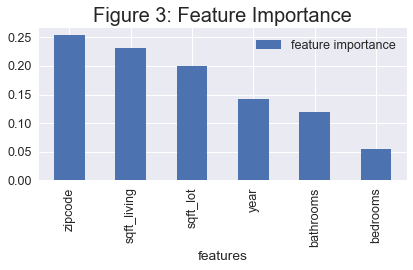

In [59]:
# plot feature importance manually
from numpy import loadtxt
from matplotlib import pyplot

fi = pd.DataFrame()
fi['features'] = df_test.columns[:-3]
fi['feature importance'] = xgb2.feature_importances_
#fi = fi.sort(['feature importance'], ascending = [0])
#fi = pd.DataFrame(fi)
fi = fi.sort_values(['feature importance'], ascending=[0])
print(fi)

# plot
fi.plot(kind='bar', x='features')
plt.title('Figure 3: Feature Importance', size = 20)
plt.tight_layout()

In [65]:
# final model 

xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=406,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 reg_alpha = 50, 
 nthread=4,
 scale_pos_weight=1,
 seed=100)

# data set used for training
print(df_train)
xgb2.fit(df_train[predictors], df_train['price'],eval_metric='rmse')
dtest_predictions = xgb2.predict(df_test[predictors])
print("r2 Score : %.4g" % metrics.r2_score(df_test['price'].values, dtest_predictions))

       bedrooms  bathrooms  sqft_living  sqft_lot  zipcode  year      price  \
0      4         2.50       2050         9143      98166    1992  360000.0    
1      3         2.50       2580         214315    98053    1986  400000.0    
2      3         1.50       2440         5750      98115    1939  875000.0    
3      3         2.50       2230         4000      98144    1954  398750.0    
4      3         3.25       2780         4002      98019    2009  402500.0    
5      4         2.75       2390         9650      98003    1976  379750.0    
6      3         1.75       1880         9360      98125    1941  445500.0    
7      3         2.25       1640         8400      98006    1962  515000.0    
8      4         2.50       2100         8800      98033    1980  610000.0    
9      3         1.00       1350         8700      98188    1942  160000.0    
10     4         2.00       1490         4054      98115    1926  607000.0    
11     4         1.50       1790         4080      9